In [1]:
from core.metrics import *
from core.semcor_bert_pipeline import load_data
from core.analysis import annotate_mtx, access_db, get_senses, fb_to_local, plot_mds
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

<Figure size 432x288 with 0 Axes>

In [2]:
shared_words = ['foot', 'table', 'plane', 'degree', 'right', 'model']
db = access_db() #Some senses that were logged were not used in expt

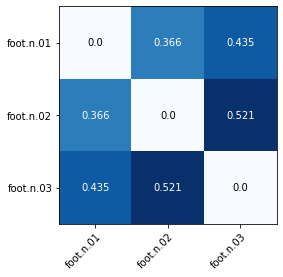

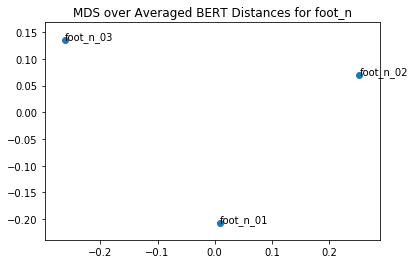

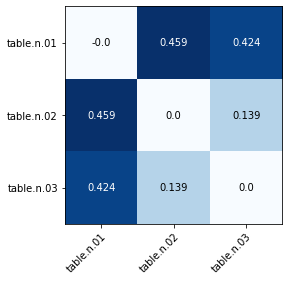

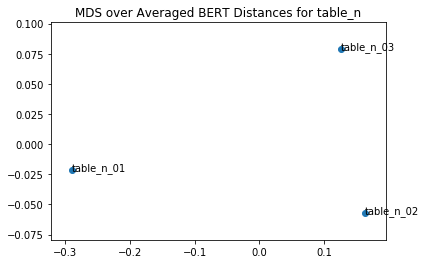

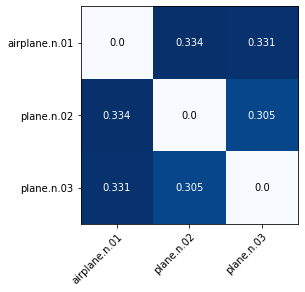

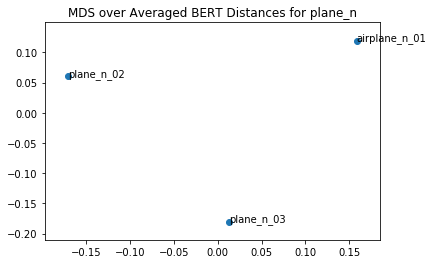

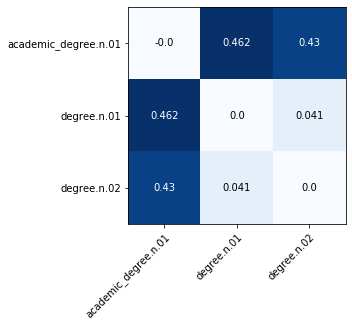

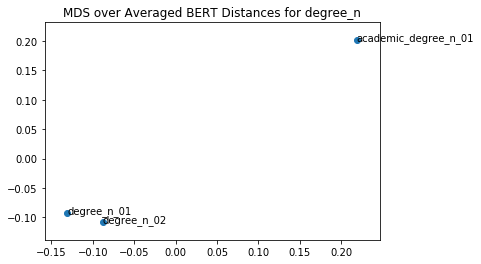

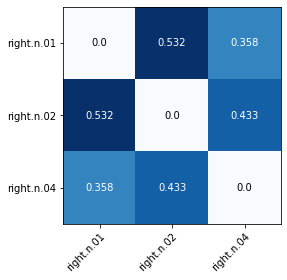

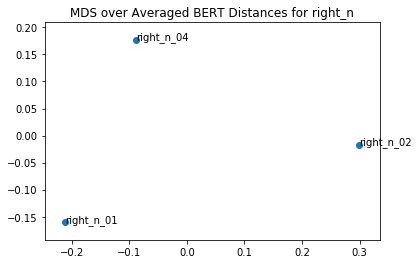

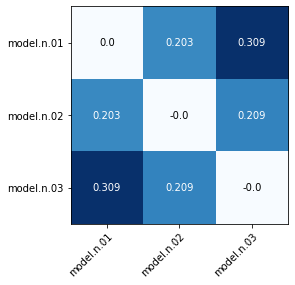

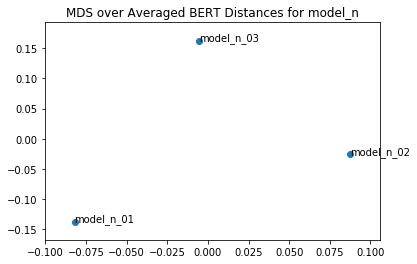

In [6]:
for w in shared_words:
    result_mtx, sense_names = cosine_sim_mtx(w, 'n',
                                             sel_senses = [fb_to_local(s) for s in get_senses(db, w + "_n")])
    fig, ax = plt.subplots()
    im = ax.imshow(1 - result_mtx)
    annotate_mtx(1 - result_mtx, im, ax, sense_names)
    mds_model = MDS(n_components = 2, dissimilarity = 'precomputed')
    plot_mds(1 - result_mtx, w + '_n', mds_model, db, "BERT")